# 합성곱 신경망

이번 장의 주제는 합성곱 신경망이다. CNN은 이미지 인식과 음성 인식 등 다양한 곳에서 사용한다.

특히, 이미지 인식 분야에서 딥러닝을 활용한 기법은 거의 다 CNN을 기초로 한다. 이번 장에서는 CNN의 메커니즘을 자세히 설명하고 이를 파이썬으로 구현해볼 것이다.

## 전체 구조

우선 CNN의 네트워크 구조를 살펴보며 전체 틀을 이해해보기로 하자.

CNN도 지금까지 본 신경망과 같이 **레고 블록처럼 계층을 조합**하여 만들 수 있다.

다만, **합성곱 계층**과 **풀링 계층**이 새롭게 등장한다. 이에 대한 상세 내용은 나중에 설명할 것이다.

여기에서는 이 계층들을 어떻게 조합하여 CNN을 만드는지를 먼저 볼 것이다.

지금까지 본 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있었다. 이를 **완전연결**이라고 하며, 완전히 연결된 계층을 Affine 계층이라는 이름으로 구현했다. 

Affine 계층을 사용하면, 가령 층이 5개인 완전연결 신경망은 [그림 7-1]과 같이 구현할 수 있다.

[229페이지 그림 7-1 참고]

[그림 7-1]과 같이 완전연결 신경망은 Affine 계층 뒤에 활성화 함수를 갖는 ReLU 계층(혹은 Sigmoid 계층)이 이어진다.

이 그림에서는 Affine-ReLU 조합이 4개가 쌓였고, 마지막 5번째 층은 Affine 계층에 이어 Softmax 계층에서 최종 결과(확률)을 출력한다.

그럼 CNN의 구조는 어떻게 다른지 한 번 보자.

[229페이지 그림 7-2 참고]

CNN에서는 새로운 **'합성곱 계층'과 '풀링 계층'이 추가**된다.

CNN에서는 'Conv - ReLU - (Pooling)' 흐름으로 연결된다(풀링 계층은 생략하기도 한다). 지금까지의 'Affine-ReLU' 연결이 'Conv-ReLU-(Pooling)'으로 바뀌었다고 생각할 수 있다.

CNN에서 주목할 또 다른 점은 **출력에 가까운 층**에서는 지금까지의 'Affine-ReLU' 구성을 사용할 수 있다는 것이다. 또, 마지막 출력 계층에서는 'Affine-Softmax' 조합을 그대로 사용한다. 이상은 일반적인 CNN에서 흔히 볼 수 있는 구성이다.

## 합성곱 계층

CNN에서는 패딩, 스트라이드 등 고유의 용어가 등장한다.

또 각 계층 사이에서는 3차원 데이터같이 **입체적인 데이터가 흐른다**는 점에서 완전연결 신경망과 다르다.

우선 이번 절에서는 CNN에서 사용하는 합성곱 계층의 구조를 차분히 살펴보도록 하자.


### 완전연결 계층의 문제점

지금까지 본 완전연결 신경망에는 완전연결 계층인 Affine 계층을 사용했다. 완전연결계층에서는 인접하는 계층의 뉴런이 모두 연결되고 출력의 수는 임의로 정할 수 있다.

완전연결 계층의 문제점은 바로 **데이터의 형상이 무시**된다는 것이다. 입력 데이터가 이미지라고 하면, 이미지는 통상 세로, 가로, 채널(색상)으로 구성된 3차원 데이터이다. 그러나 완전연결 계층에 입력할 때에는 3차원 데이터를 **평평한 1차원 데이터로 평탄화해주어야 한다.** 지금까지 MNIST 데이터셋을 사용한 사례에서는 형상이 $(1,28,28)$인 이미지를 1줄로 세운 784개의 데이터를 첫 Affine 계층에 입력했다.

이미지는 3차원 형상이며, 이 형상에는 공간적 정보가 담겨 있다.

예를 들어 공간적으로 가까운 픽셀은 값이 비슷하거나, RGB의 각 채널은 서로 밀접하게 관련되어 있거나, 거리가 먼 픽셀끼리는 별 연관이 없는 등, **3차원 속에서 의미를 갖는 본질적인 패턴**이 숨어 있을 것이다. 그러나 완전연결 계층은 형상을 무시하고 모든 입력 데이터를 동등한 뉴런(같은 차원의 뉴런)으로 취급하여 형상에 담긴 정보를 살릴 수 없다.

한편, 합성곱 계층은 **형상을 유지**한다. 이미지도 3차원 데이터로 입력받으며, 마찬가지로 다음 계층에도 3차원 데이터로 전달한다. 그래서 CNN에서는 이미지처럼 형상을 가진 데이터를 제대로 이해할 (가능성이 있는) 것이다.

CNN에서는 합성곱 계층의 입출력 데이터를 **특징 맵**이라고도 한다. 합성곱 계층의 입력 데이터를 **입력 특징 맵**, 출력 데이터를 **출력 특징 맵**이라고 하는 식. 이 책에서는 '입출력 데이터'와 '특징 맵'을 같은 의미로 사용한다.

### 합성곱 연산

합성곱 계층에서의 **합성곱 연산**을 처리한다. 합성곱 연산은 이미지 처리에서 말하는 **필터 연산**에 해당한다.

<font color = blue> [231페이지 그림 7-3 참고] </font>

합성곱 연산은 입력 데이터에 필터를 적용한다.

위 그림의 예에서 입력 데이터는 세로 X 가로의 형상을 가졌고, 필터 역시 세로 X 가로의 차원을 갖는다. 데이터와 필터의 형상을 (높이, 너비)로 표현하며, 이 예에서는 입력은 $(4,4)$, 필터는 $(3,3)$, 출력은 $(2,2)$가 된다.

합성곱 연산은 필터의 **윈도우**를 일정 간격으로 이동해가며 입력 데이터에 적용한다. 여기서 말하는 윈도우는 [그림 7-4]의 회색 3X3을 가리킨다. 이 그림에서 보듯, 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구한다(이 계산을 **단일 곱셈-누산**이라고 한다). 그리고 그 출력을 해당 장소에 저장한다. 이 과정을 모든 장소에서 수행하면 합성곱 연산의 출력이 완성된다.

<font color = blue> [232페이지 그림 7-4 참고] **중요!!!** </font>

완전연결 신경망에는 가중치 매개변수와 편향이 존재하는데, CNN에서는 **필터의 매개변수**가 그동안의 가중치에 해당한다. 그리고 CNN에서도 **편향이 존재**하는데, 편향까지 보여주면 [그림 7-5]와 같은 흐름이 된다.

<font color = blue> [233페이지 그림 7-5 참고] **중요!!!** </font>

위 그림과 같이 편향은 **필터를 적용한 후의 데이터에 더해진다**. 그리고 편향은 항상 하나(1X1)만 존재한다. 그 하나의 값을 필터를 적용한 모든 원소에 더하는 것이다.

### 패딩

합성곱 연산을 수행하기 전에 입력 데이터 주변을 **특정 값(예컨대 0)** 으로 채우기도 한다. 이를 **패딩**이라고 하며, 합성곱 연산에서 자주 이용하는 기법이다. 예를 들어 [그림 7-6]은 $(4,4)$ 크기의 입력 데이터에 폭이 1인 패딩을 적용한 모습이다. 폭 1짜리 패딩이라 하면 **입력 데이터 사방 1픽셀을 특정 값으로 채우는 것** 이다.

<font color = blue> [233페이지 그림 7-6 참고] </font>

    합성곱 연산의 패딩 처리 : 입력 데이터 주위에 0을 채운다. 패딩은 점선으로 표시했으며 그 안의 값 '0'을 생략했다.
    
[그림 7-6]과 같이 처음에 크기가 $(4,4)$인 입력 데이터에 패딩이 추가되어 $(6,6)$이 된다.

이 입력에 $(3,3)$ 크기의 필터를 걸면 $(4,4)$ 크기의 출력 데이터가 생성된다.

이 예에서는 패딩을 1로 설정했지만, 2와 3 등 원하는 정수로 설정할 수 있다. 만약 [그림 7-5]에 패딩을 2로 설정하면 입력 데이터의 크기는 $(8,8)$이 되고, 3으로 설정하면 $(10, 10)$이 된다. (<font color = purple> 가로와 세로가 모두 늘어나므로! </font>)

<font color = blue> *NOTE. 패딩은 주로 출력 크기를 조정할 목적으로 사용한다. 예를 들어 $(4,4)$ 입력 데이터에 $(3,3)$ 필터를 적용하면 출력은 $(2,2)$가 되어, 입력보다 2만큼 줄어든다. 이는 합성곱 연산을 몇 번이나 되풀이하는 심층 신경망에서는 문제가 될 수 있다. 합성곱 연산을 거칠 때마다 크기가 작아지면 어느 시점에서는 출력 크기가 1이 되어버린다. 더 이상 합성곱 연산을 적용할 수 없다는 것이다. 이러한 사태를 막기 위해 패딩을 사용한다. 앞의 예에서는 패딩의 폭을 1으로 설정해 입력에 대한 출력이 같은 크기인 $(4,4)$로 유지되었다. 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달할 수 있다는 것이다.* </font>

### 스트라이드

필터가 적용하는 위치의 간격을 **스트라이드**라고 한다. 지금까지 본 예는 모두 스트라이드가 1이었지만, 예를 들어 스트라이드를 2로 하면 **필터를 적용하는 윈도우가 두 칸씩 이동** 한다.

<font color = blue> [234페이지 그림 7-7 참고] </font>

이철머 스트라이드를 키우면 **출력 크기는 작아진다**. 한편, 패딩을 크게 하면 **출력 크기가 커진다**. 이러한 관계를 수식화라면 어떻게 될까? 이어서 패딩, 스트라이드, 출력 크기를 어떻게 계산하는지 살펴보자.

입력 크기를 $(H, W)$, 필터 크기를 $(FH, FW)$, 출력 크기를 $(OH, OW)$, 패딩을 $P$, 스트라이드를 $S$라 한다면, 출력 크기는 다음과 같은 식으로 계산한다.

$$OH = \frac{H + 2P - FH}{S} + 1 \\
OW = \frac{W + 2P - FW}{S} + 1$$

이 식을 사용하여 연습을 해보자.

예 1. [그림 7-6]의 예
    입력 (4,4), 패딩 : 1, 스트라이드 : 1, 필터 : (3,3)
    
$$OH = \frac{4 + 2 \cdot 1 - 3}{1} + 1 = 4 \\
OW = \frac{4 + 2 \cdot 1 - 3}{1} + 1 = 4$$


예 2. [그림 7-7]의 예
    입력 (7,7), 패딩 : 0, 스트라이드 : 2, 필터 : (3,3)
    
$$OH = \frac{7 + 2 \cdot 0 - 3}{2} + 1 = 3 \\
OW = \frac{7 + 2 \cdot 0 - 3}{2} + 1 = 3$$

예 3.
    입력 : (28, 31), 패딩 : 2, 스트라이드 : 3, 필터 (5,5)

$$OH = \frac{28 + 2 \cdot 2 - 5}{3} + 1 = 10 \\
\frac{31 + 2 \cdot 2 - 5}{3} + 1 = 11$$

이상의 예처럼 위의 식에 단순히 값을 대입하기만 하면 **출력 크기를 구할 수 있다**.

단, $\frac{W + 2P - FW}{S}, \frac{H + 2P - FH}{S}$가 **정수로 나눠떨어지는 값이어야 한다는 점**에 주의하자.

딥러닝 프레임워크 중에는 딱 나눠떨어지지 않을 때는 가장 가까운 정수롤 반올림 하는 등, 특별히 에러를 내지 않고 진행하도록 구현하는 경우도 있다.

### 3차원 데이터의 합성곱 연산

지금까지 2차원 형상을 다루는 합성곱 연산을 살펴보았다.

그러나 이미지만 해도 세로, 가로, 채널까지 고려한 3차원 데이터이다. 이번 절에는 조금 전과 같은 순서로 체널까지 고려한 3차원 데이터를 다루는 합성곱 연산을 살펴볼 것이다.

[그림 7-8]은 3차원 데이터의 합성곱 연산 예이고, [그림 7-9]는 계산 순서이다. 2차원일 때와 비교하면, 길이 방향(채널 방향)으로 특징 맵이 늘어났다. 채널 쪽으로 특징 맵이 여러 개 있다면, 입력 데이터와 필터의 합성곱 연산을 채널마다 수행하고, 그 결과를 더해서 하나의 출력을 얻는다.

<font color = blue> [236~237페이지 그림 7-8, 7-9 참고] **중요!!** </font>

3차원의 합성곱 연산에서 주의할 점은 **입력 데이터의 채널 수와 필터의 채널 수가 같아야 한다**는 것이다. 이 예에서는 모두 3개로 일치한다.

필터 자체의 크기는 원하는 값으로 설정할 수 있는데, 모든 채널의 필터가 같은 크기여야 한다.

이 예에서는 필터의 크기가 $(3,3)$이지만 원한다면 $(2,2), (1,1), (5,5)$ 등으로 설정해도 무방하다.

### 블록으로 생각하기

3차원의 합성곱 연산을 데이터와 필터를 직육면체 블록이라고 생각하면 쉽다.

블록은 [그림 7-10]과 같은 3차원 직육면체이다. 또, 3차원 데이터를 다차원 배열로 나타낼 대에는 (채널, 높이, 너비) 순서로 쓸 것이다. 필터도 같은 순서이다.

<font color = blue> [238페이지 그림 7-10 참고] </font>

이 예에서 출력 데이터는 한 장의 특징 맵이다. 한 장의 특징 맵을 다른 말로 하면 **채널이 1개인 특징 맵**이다.

그럼 합성곱 연산의 출력으로 다수의 채널을 내보내려면 어떻게 해야 할가? 그 답은 필터(가중치)를 다수 사용하는 것이다. 그림으로는 [그림 7-11]처럼 된다.

<font color = blue> [239페이지 그림 7-11 참고] </font>

이 그림과 같이 필터를 $FN$개 적용하면 출력 맵도 $FN$개가 생성된다. 그리고 그 $FN$개의 맵을 모으면 형상이 $(FN, OH, OW)$인 블록이 완성된다. 이 완성된 블록을 다음 계층으로 넘기는 것이 CNN의 처리 흐름이다.

이와 같이 합성곱 연산에서는 **필터의 수도 고려**해야 한다. 그런 이유로 필터의 가중치 데이터는 4차원 데이터이며 (출력 채널 수, 입력 채널 수, 높이, 너비) 순으로 쓴다. 예를 들어 채널 수 3, 크기 5X5인 필터가 20개 있다면 $(20, 3, 5, 5)$로 쓴다.

합성곱 연산에도 편향이 쓰인다. [그림 7-12]은 [그림 7-11]에 편향을 더한 모습이다.

<font color = blue> [239페이지 그림 7-12 참고] </font>

======

$(C, H, W) * (FN, C, FH, FW) \rightarrow (FN, OH, OW) + (FN, 1, 1) \rightarrow (FN, OH, OW)$

$*$은 합성곱 연산

======

위 그림에서 보듯 편향은 채널 하나에 값 하나씩으로 구성된다. 이 예에서는 편향의 형상은 $(FN, 1, 1)$이고, 필터의 출력 결과의 형상은 $(FN, OH, OW)$이다. 이 두 블록을 더하면 편향의 각 값이 필터의 출력인 $(FN, OH, OW)$ 블록의 대응 채널의 **원소 모두에 더해진다.**

형상이 다른 블록의 덧셈은 넘파이의 브로드캐스트 기능으로 쉽게 구현할 수 있다.

### 배치 처리

신경망 처리에서는 입력 데이터를 한 덩어리로 묶어 배치로 처리했다. 완전연결 신경망을 구현하면서는 이 방식을 지원하여 처리 효율을 높이고, 미니배치 방식의 학습도 지원하도록 했다.

합성곱 연산도 마찬가지로 배치 처리를 지원하고자 한다. 그래서 각 계층을 흐르는 데이터의 차원을 하나 늘려 **4차원 데이터로 저장**한다. 구체적으로는 데이터를 (데이터 수, 채널 수, 높이, 너비) 순으로 저장한다. 데이터가 N개 일 때, [그림 7-12]를 배치 처리한다면 데이터 형태가 [그림 7-13]처럼 된다.

=======

$(N, C, H, W) * (FN, C, FH, FW) \rightarrow (N, FN, OH, OW) + (FN, 1, 1) \rightarrow (N, FN, OH, OW)$

$*$은 합성곱 연산, $(FN, 1, 1)$은 편향

======

배치 처리 시의 데이터 흐름을 나타낸 위 그림을 보면 각 데이터의 선두에 배치용 차원을 추가했다.

이처럼 데이터는 4차원 형상을 가진 채 각 계층을 타고 흐른다. 여기에서 주의할 점으로는 신경망에 4차원 데이터가 하나 흐를 때마다 데이터 N개에 대한 합성곱 연산이 이뤄진다는 것이다. 즉, N회 분의 처리를 한 번에 수행하는 것이다.

## 풀링 계층

풀링은 세로, 가로 방향의 공간을 줄이는 연산이다. 예를 들어 [그림 7-14]와 같이 2X2 영역을 원소 하나로 집약하여 공간 크기를 줄인다.

<font color = blue> [241페이지 그림 7-14 참고] </font>

[그림 7-14]는 2X2 **최대 풀링**을 스트라이드 2로 처리하는 순서이다. 최대 풀링은 **최댓값을 구하는 연산**으로, '2X2'는 대상 영역의 크기를 말한다.

따라서 2X2 최대 풀링은 **2X2 크기의 영역에서 가장 큰 원소 하나를 꺼내는 것** 이다.

또, 스트라이드는 이 예에서는 2로 설정했으므로, 2X2 윈도우가 **원소 2칸 간격으로 이동**한다. 이 풀링의 윈도우 크기와 스트라이드는 **같은 값으로 설정** 하는 것이 보통이다. 예를 들어 윈도우 3X3이면 스트라이드는 3으로, 윈도우 4X4이면 스트라이드를 4로 설정한다.

풀링은 최대 풀링 외에도 **평균 풀링**이 있다. 최대 풀링은 대상 영역에서 최댓값을 취하는 연산인 반면, 평균 풀링은 대상 영역의 평균을 계산한다. 이미지 인식 분야에서는 주로 최대 풀링을 사용한다.

그러므로 여기에서 풀링 계층은 최대 풀링으로 통일하겠다.

### 풀링 계층의 특징

풀링 계층의 특징을 정리해보자.

<font color = gray> **학습해야 할 매개변수가 없다** </font>
    풀링 계층은 합성곱 계층과 달리 학습해야 할 매개변수가 없다. 풀링은 대상 영역에서 최댓값이나 평균을 취하는 명확한 처리이므로 특별히 학습할 것이 없다.

<font color = gray> **채널 수가 변하지 않는다** </font>
    풀링 연산은 입력 데이터의 채널 수 그대로 출력 데이터로 내보낸다. [그림 7-15]처럼 채널마다 독립적으로 계산한다.
    
<font color = blue> [242페이지 그림 7-15 참고] </font>

<font color = gray> **입력의 변화에 영향을 적게 받는다(강건하다)** </font>
    입력 데이터가 조금 변해도 풀링의 결과는 잘 변하지 않는다. 

## 합성곱/풀링 계층 구현하기

지금까지 합성곱 계층과 풀링 계층에 대해 자세히 설명했다. 이번 절에서는 이 두 계층을 파이썬으로 구현해볼 것이다.

합성곱 계층과 풀링 계층은 복잡해 보이지만, 트릭을 사용하면 쉽게 구현할 수 있다.

이번 절에서는 그 트릭을 활용해 문제를 간단히 하면서 합서옥ㅂ 계층을 구현해볼 것이다.

### 4차원 배열

CNN에서 계층 사이를 흐르는 데이터는 4차원이다.

예를 들어, 데이터의 형상이 $(10, 1, 28, 28)$이라면, 이는 높이 28, 너비 28, 채널 1개인 데이터가 10개라는 이야기이다.

이를 파이썬으로 구현하면 다음과 같다.

In [3]:
import numpy as np
x = np.random.rand(10, 1, 28, 28) # 무작위로 데이터 생성
x.shape

(10, 1, 28, 28)

여기에서 10개 중 첫 번째 데이터에 접근하려면 단순히 $x[0]$이라고 쓴다.

In [4]:
x[0].shape

(1, 28, 28)

In [5]:
x[1].shape

(1, 28, 28)

또, 첫 번재 데이터의 첫 채널의 공간 데이터에 접근하려면 다음과 같이 적는다.

In [13]:
import pandas as pd
xp = x[0, 0] # 또는 x[0][0]
xp.ndim

2

이처럼 CNN은 4차원 데이터를 다룬다. 그래서 합성곱 연산의 구현은 복잡해질 것 같지만, 다음 절에서 설명하는 im2col이라는 트릭이 문제를 단순하게 만들어준다.

### im2col로 데이터 전개하기

합성곱 연산을 곧이곧대로 구현하려면 for 문을 겹겹이 써야할 것이다. 

하지만 넘파이에 for 문을 사용하면 성능이 떨어진다는 단점이 있다(넘파이에서는 원소에 접근할 때 for 문을 사용하지 않는 것이 바람직하다).

이번 절에서는 for 문 대신 im2col이라는 편의 함수를 사용해 간단하게 구현해 볼 것이다.

im2col은 입력 데이터를 필터링(가중치 계산)하게 좋게 전개하는(펼치는) 함수이다. 

[그림 7-17]과 같이 3차원 입력 데이터에 im2col을 적용하면 2차원 행렬로 바뀐다(정확히는 배치 안의 데이터 수까지 포함한 4차원 데이터를 2차원으로 변환한다). 즉, im2col은 필터 적용 영역을 앞에서 순서대로 1줄로 펼친다.

im2col은 필터링하게 좋게 입력 데이터를 전개한다. 구체적으로는 [그림 7-18]과 같이 입력 데이터에서 **필터를 적용하는 영역(3차원 블록)을 한 줄로 늘어놓는다**. 이 전개를 필터를 적용하는 모든 영역에서 수행하는 것이 im2col이다.

<font color = blue> [244페이지 그림 7-17, 그림 7-18 참고] </font>

[그림 7-18]에서는 보기 좋게끔 스트라이드를 크게 잡아 필터의 적용 영역이 겹치지 않도록 했지만, 실제 상황에서는 영역이 겹치는 경우가 대부분이다.

필터 적용 영역이 겹치게 되면 im2col로 전개한 후의 원소 수가 원래 블록의 원소 수보다 많아진다. 그래서 im2col을 사용해 구현하면 메모리르 더 많이 소비하는 단점이 있다.

<font color = purple> 겹치는 원소를 중복해서 쓸수밖에 없으니, 블록의 원소 수보다 전개 후 원소 수가 많아질 수밖에 없다. </font>

하지만 컴퓨터는 큰 행렬을 묶어서 계산하는 데 탁월하다.

예를 들어 행렬 계산 라이브러리 등은 행렬 계산에 고도로 최적화되어 큰 행렬의 곱셈을 빠르게 꼐산할 수 있다. 그래서 문제를 행렬 계산으로 만들면 선형 대수 라이브러리를 활용해 효율을 높일 수 있다.

<font color = blue> *NOTE. im2col은 'image to column', 즉 이미지에서 행렬로라는 뜻이다. Caffe나 Chainer 등의 딥러닝 프레임워크는 im2col이라는 이름의 함수를 만들어 합성곱 계층을 구현할 때 이용하고 있다.* </font>

im2col로 입력 데이터를 전개한 다음에는 **합성곱 계층의 필터(가중치)를 1열로 전개**하고, 두 행렬의 곱을 계산하면 된다.

이는 완전연결 계층의 Affine 계층에서 한 것과 거의 같다.

<font color = blue> [245페이지 그림 7-19 참고] </font>

[그림 7-19]와 같이 im2col 방식으로 출력한 결과는 2차원 행렬이다. CNN은 데이터를 4차원 배열로 저장하므로 출력 데이터를 4차원으로 변형한다. 이상이 합성곱 계층의 구현 흐름이다.

### 합성곱 계층 구현하기

이 책에서는 im2col 함수를 미리 만들어 제공한다.

    im2col 함수는 간단한 함수 10개 정도를 묶은 것이니, 궁금하면 common/util.py를 참고하자.

In [16]:
import sys, os
os.chdir("/Users/choeunsol/deep-learning-from-scratch-master/ch07")
sys.path.append(os.pardir)
from common.util import im2col

    im2col(input_data, filter_h, filter_w, stride = 1, pad = 0)
    
    - input_data : (데이터 수, 채널 수, 높이, 너비)의 4차원 배열로 이뤄진 입력 데이터
    - filter_h : 필터의 높이
    - filter_w : 필터의 너비
    - stride : 스트라이드
    - pad : 패딩
    
이 im2col은 '필터 크기', '스트라이드', '패딩'을 고려하여 입력 데이터를 2차원 배열로 전개한다.

그렇다면 이 im2col을 실제로 사용해보자.

In [19]:
x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널, 높이, 너비)
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)

(9, 75)


In [20]:
x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape)

(90, 75)


여기에서는 두 가지 예를 보여주고 있다.

첫 번째는 배치 크기가 1(데이터 1개), 채널은 3개, 높이와 너비가 각각 7X7인 데이터이고,

두 번째는 배치 크기만 10이고 나머지는 첫 번째와 같다.

im2col 함수를 적용한 두 경우 모두 2번째 차원의 원소는 75개이다. 이 값은 필터의 원소 개수와 같다(채널 3개, 5X5데이터).

또한, 배치 크기가 1일 때는 im2col의 결과의 크기가 $(9,75)$이고, 10일 때는 그 10배인 $(90, 75)$ 크기의 데이터가 저장된다.

<font color = purple> 필터의 크기가 $(5,5)$이고 출력 특징 맵의 크기가 $(7,7)$이기 때문에, 한 채널 당 윈도우가 9번 이동한다(가로 3번, 세로 9번). 이 필터에 따른 합성곱에 필요한 요소들을 펼쳐놓은 것이 im2col의 열 개수인 75개. 따라서 5X5X3의 차원을 가지게 된다. </font>

이제 이 im2col을 사용하여 합성곱 계층을 구현해보자. 여기에서는 합성곱 계층을 Convolution이라는 클래스로 구현할 것이다.

In [21]:
class Convolution:
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape # 필터의 채널과 입력 데이터의 채널 수를 맞춰야 함에 주의!!
        out_h = int(1+(H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride) 
        ## 2차원일 때의 출력 h, w을 계산하는 방법을 기억하자.
        
        col = im2col(x, FH, FW, self.stride, self.pad) 
        ## im2col은 입력값을 필터에 맞게 전개한다.
        col_W = self.W.reshape(FN, -1).T 
        ## 하나의 필터 당 계산을 해야하므로 필터의 개수만큼을 지정해놓고 펼쳐준다. 
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)
        
        return out

    합성곱 계층은 필터(가중치), 편향, 스트라이드, 패딩을 인수로 받아 초기화된다. 필터는 (FN, C, FH, FW)의 4차원 형상.
    
    col = im2col(...) ~ out = np.dot(...) + b 부분에서 입력 데이터를 im2col로 전개하고 필터도 reshape를 통해 2차원 배열로 전개한다. col과의 곱을 위해 행렬을 transpose 해준다. 
    
    reshape(..., -1) 옵션은 행의 개수가 정해지고 데이터가 빠짐없이 들어가도록 열의 개수를 자동으로 정해준다. 필터의 개수만큼 행을 정의했으므로 한 필터의 해당 요소들을 열로 정의한다. 앞에서 정의한 im2col로 펼친 x의 2차원 배열과 호응하도록 한다. x의 단위가 필터 하나에 곱하는 원소들을 하나의 열로 정리했으므로, col_W도 마찬가지로 필터 하나를 모두 한 열에 집어넣는다.
    
    앞의 코드에서 (10, 3, 5, 5) 형상을 한 다차원 배열 W의 원소 개수는 총 750개이다. 이 배열에 reshape(10, -1)을 호출하면 750개의 원소를 10묶음인 (10, 75)인 배열로 만들어준다.
    
    forward 구현의 마지막에서는 출력 데이터를 적절한 형상으로 바꿔준다. 이 때 넘파이의 transpose 함수를 사용하는데, 이는 다차원 배열의 축 순서를 바꿔주는 함수이다. 즉, 원래 행렬이 (0,1,2,3)이라면 transpose(0,3,1,2)는 배열 순서를 인덱스 순서대로 바꿔준다.
    
<font color = blue> [248페이지 그림 7-20 참고] </font>

이상이 합성곱 계층의 forward 구현이다. im2col로 전개한 덕분에 완전연결 계층의 Affine 계층과 거의 똑같이 구현할 수 있었다.

합성곱 계층의 역전파는 Affine 계층의 구현과 유사하다. 주의할 것은, 합성곱 계층의 역전파에서는 im2col을 역으로 처리해야 한다. 이는 이 책에서 제공하는 col2im 함수를 사용하면 된다(col2im의 구현은 common/util.py에 있다). col2im을 사용한다는 점만 제외하면 합성곱 계층의 역전파는 Affine 계층과 똑같다.

In [23]:
from common.util import col2im

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        ## 정방향에서의 4차원 배열을 만들기 위해 결과물을 transpose해준다.

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

   Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들

### 풀링 계층 구현하기

풀링 계층 구현도 합성곱 계층과 마찬가지로 im2col을 사용해 입력 데이터를 전개한다.

단, 풀링의 경우에는 **채널 쪽이 독립적이라는 점**이 합성곱 계층 때와 다르다. 구체적으로는 [그림 7-21]과 같이 풀링 적용 영역을 채널마다 독립적으로 전개한다.

<font color = blue> [249페이지 그림 7-21 참고] </font>

입력 데이터에 풀링 적용 영역을 전개하고, 전개한 행렬에서 행별 최댓값을 구하는 식으로 풀링을 실행한다.

이를 적절한 형상으로 변환하기만 하면 된다.

In [27]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        ## 먼저 풀링의 범위를 정한다. pool_h와 pool_w은 풀링 범위이다. w*h 풀링을 의미한다.
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        ## self.pool_w * self.pool_h의 범위로 데이터를 펼친다. 2차원 배열
        col = col.reshape(-1, self.pool_h * self.pool_w)
        ## 이것을 다시 self.pool_w * self.pool_h 크기의 행으로 만들기 위해 재배열한다.
        ## 풀링은 채널마다 독립적으로 계산되므로 im2col에서 채널을 합쳤담녀 반대로 reshape를 통해 분리해준다.
        ## 이렇게 되면 데이터 수만큼 self.pool_w * self.pool_h 크기의 행들이 만들어진다.
        
        # 최댓값 (2)
        arg_max = np.argmax(col, axis = 1) # np.argmax은 최댓값의 인덱스를 반환한다.
        out = np.max(col, axis = 1)
        ## 풀링 단위의 데이터가 행으로 펼쳐졌으므로 행에서 max value를 찾을 수 있도록 axis = 1으로 최댓값을 뽑아준다.
        
        # 성형 (3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        ## 펼쳐놓은 데이터를 다시 돌려놓는다.
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        ## 형상을 forward에서 빠져나오기 전으로 바꿔준다.
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

풀링 계층 구현은 다음의 세 단계로 진행된다.

1. 입력 데이터를 전개한다.
2. 행별 최댓값을 구한다.
3. 적절한 모양으로 성형한다.

앞의 코드에서와 같이 각 단계는 한두 줄 정도로 간단히 구현된다.

이상이 풀링 계층의 forward 처리이다. 이 절에서 선택한 전략을 따라 입력 데이터를 풀링하기 쉬운 형태로 전개해버리면 그 후의 구현은 간단하다.

## CNN 구현하기

합성곱 계층과 풀링 계층을 구현했으니, 이 계층을 조합하여 손글씨 숫자를 인식하는 CNN을 조립해보자.

여기에서는 1층 (Conv - ReLU - Pooling) / 2층 (Affine - ReLU) / 3층 (Affine - Softmax)로 하는 CNN을 구현한다.

이를 SimpleConvNet이라는 이름의 클래스로 구현한다.

    우선 SimpleConvNet의 초기화 (__init__)을 살펴보자. 초기화할 때는 다음과 같은 인수를 받는다.
    
    input_dim : 입력 데이터(채널 수, 높이, 너비)의 차원
    conv_param : 합성곱 계층의 하이퍼파라미터(딕셔너리). 딕셔너리의 키는 다음과 같다.
        - filter_num : 필터 수
        - filter_size : 필터 크기
        - stride : 스트라이드
        - pad : 패딩
    hidden_size : 은닉층(완전연결)의 뉴런 수
    output_size : 출력층(완전연결)의 뉴런 수
    weight_init_std : 초기화 때의 가중치 표준편차
    
여기에서 합성곱 계층의 하이퍼파라미터는 딕셔너리 형태로 주어진다(conv_param).

이것은 필요한 하이퍼파라미터의 값이 예컨대 ['fiter_num' : 30, 'filter_size' : 5, 'pad' : 0, 'stride' : 1] 처럼 저장된다는 것이다.

In [26]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

class SimpleConvNet:
    def __init__(self, input_dim = (1, 28, 28),
                 conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size = 100, output_size = 10, weight_init_std = 0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['filter_pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1] # size로 행을 넣어준다.
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'],
                                          conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h = 2, pool_w = 2, stride = 2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        return grads

ModuleNotFoundError: No module named 'simple_convnet'

우선, 초기화 인수로 주어진 함성곱 계층의 하이퍼파라미터를 딕셔너리에서 꺼낸다 (나중에 쓰기 쉽도록)

    filter_num = conv_param['filter_num']
    ---
    filter_stride = conv_param['stride'] 가 이 부분이다.
    
그리고 합성층 계층의 출력 크기를 계산한다.

학습에 필요한 매개변수는 1번째 층의 합성곱 계층과 나머지 두 완전연결 계층의 가중치와 편향이다.

이 매개변수들을 인스턴스 변수 params 딕셔너리에 저장한다.

    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size) 이 이 부분이다.
    
학습에 필요한 매개변수는 1번째 층의 합성곱 계층과 나머지 두 완전연결 계층의 가중치와 편향이다.

이 매개변수를 parmas 딕셔너리에 저장한다. 1번째 층의 합성곱 계층의 가중치는 W1, 편향은 b1 , ... 이런 식으로 저장한다.

마지막으로 CNN을 구성하는 계층을 생성한다.

순서가 있는 딕셔너리인 OrdereDict()에 self.layers을 생성한 후 계층들을 차례대로 추가한다.

마지막 SoftmaxWithLoss 계층은 last_layer라는 별도 변수에 저장한다.

이렇게 초기화를 마친 다음에는 추론을 수행하는 predict 메서드와 손실 함수 값을 구하는 loss 메서드을 위와 같이 구현할 수 있다.

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x):
        y = self.predict(x)
        return self.last_layer.forward(y, t) 이 이 부분이다.
        
    이 코드에서 x는 입력 데이터, t는 정답 레이블이다.

    추론을 수행하는 predict 메서드는 초기화 때 layers에 추가한 계층을 맨 앞에서부터 차례로 forward 메서드를 호출하며 그 결과를 다음 계층에 전달한다.
    
    손실 함수를 구하는 loss 메서드는 predict 메서드의 결과를 인수로 마지막 층의 forward 메서드를 호출한다.
    
    즉, 첫 계층부터 마지막 계층까지 forward를 처리한다.
    
이어서, 오차역전파법으로 기울기를 구한다.

매개변수의 기울기는 오차역전파법으로 구하며, 이 과정은 순전파와 역전파를 반복한다.

순전파와 역전파를 제대로 구현했다면 여기에서는 단지 그것들을 적절한 순서로 호출만 해주면 된다.

마지막으로 grads라는 딕셔너리 변수에 각 가중치 매개변수들을 저장한다.

이에 따라서 SimpleConvNet으로 MNIST 데이터셋을 학습해보자.

train loss:2.2995592150934097
=== epoch:1, train acc:0.093, test acc:0.107 ===
train loss:2.2959484544564437
train loss:2.2862635412385
train loss:2.2822068972606955
train loss:2.274773909288874
train loss:2.263774387085139
train loss:2.256503856385622
train loss:2.2397328007809123
train loss:2.233057599141265
train loss:2.169100062417902
train loss:2.1681295241619805
train loss:2.122498706977855
train loss:2.035566536783097
train loss:2.033298648862059
train loss:1.9447856747950585
train loss:1.9305924626148385
train loss:1.8942899003057163
train loss:1.744578797549061
train loss:1.6607158208782813
train loss:1.6531666223433237
train loss:1.5147638200259594
train loss:1.5005980221095367
train loss:1.332825081247106
train loss:1.3214473477872253
train loss:1.2669213930610816
train loss:1.1099367690165882
train loss:1.0403245521444646
train loss:1.0956553624272083
train loss:1.2025090925087807
train loss:0.8605838408653771
train loss:0.9408856962432042
train loss:0.9273962539207271
trai

train loss:0.16480698896765453
train loss:0.30902187584705226
train loss:0.1598556013404212
train loss:0.34056595888477753
train loss:0.19822587679721404
train loss:0.24620278334782777
train loss:0.24008996496405216
train loss:0.31461189712337356
train loss:0.3301646736984456
train loss:0.3719360231715085
train loss:0.2792482763016386
train loss:0.27414484387016824
train loss:0.42754725978712166
train loss:0.23188923142637005
train loss:0.21968333664259443
train loss:0.24356131594538616
train loss:0.24647503685176544
train loss:0.28688825225878406
train loss:0.12931213675834166
train loss:0.2526311913402214
train loss:0.2697726298013642
train loss:0.4579024325006674
train loss:0.34179833468331255
train loss:0.17499426701585175
train loss:0.18424639498856143
train loss:0.4556852130874029
train loss:0.16892348624375836
train loss:0.30384336648030535
train loss:0.2508018364511508
train loss:0.1972577333913775
train loss:0.29733897889639455
train loss:0.23776648308765339
train loss:0.28338

train loss:0.1459246365930462
train loss:0.2576323443819074
train loss:0.11220348720365819
train loss:0.10958162551581328
train loss:0.11651627572854432
train loss:0.15092053931291224
train loss:0.08920292339113897
train loss:0.10822796787511826
train loss:0.12351021056577832
train loss:0.07665928864936691
train loss:0.12684289824189623
train loss:0.1120037244131668
train loss:0.09674921773231772
train loss:0.15049603757553603
train loss:0.2727483045887521
train loss:0.19878402576290502
train loss:0.17539096071033022
train loss:0.17239263716962383
train loss:0.17462177061326525
train loss:0.1493209392196542
train loss:0.10937897828397179
train loss:0.0680006225174387
train loss:0.1852232799505067
train loss:0.13717438472117674
train loss:0.05925244706948206
train loss:0.16588561295352935
train loss:0.1579719658758133
train loss:0.14580987639396822
train loss:0.0810091963378457
train loss:0.10807447843055956
train loss:0.09209336971256885
train loss:0.16946697746525097
train loss:0.3110

train loss:0.10505522259646279
train loss:0.12369154602369521
train loss:0.0860088764904873
train loss:0.11440916611215003
train loss:0.0491814546767791
train loss:0.06450511138840785
train loss:0.19042398351479592
train loss:0.0697596948267052
train loss:0.11805434672499013
train loss:0.14610473013712605
train loss:0.11705830814097812
train loss:0.12530588057475417
train loss:0.10331089387096792
train loss:0.09078337286323061
train loss:0.14754038332848507
train loss:0.12917331498439094
train loss:0.06316764883595699
train loss:0.2131790856343057
train loss:0.06589885802127216
train loss:0.07738648455159242
train loss:0.04233751801393125
train loss:0.08574269840815614
train loss:0.15781230713767525
train loss:0.06118486243947957
train loss:0.12384951794021153
train loss:0.10800032395958656
train loss:0.030213540555647768
train loss:0.2149524185741861
train loss:0.13306454251537583
train loss:0.12490150231524605
train loss:0.10892898829407338
train loss:0.05965082072703914
train loss:0

train loss:0.040355372233922084
train loss:0.02581111007698573
train loss:0.11517962574151089
train loss:0.07687249662513587
train loss:0.07842233572282556
train loss:0.09240540407491771
train loss:0.06907350267686746
train loss:0.08089839021069616
train loss:0.11286219949885451
train loss:0.05267909580914174
train loss:0.12333953509653503
train loss:0.04607776091594179
train loss:0.07827944880189887
train loss:0.07664351198301082
train loss:0.0719855826774542
train loss:0.12416380091792435
train loss:0.12025556515490797
train loss:0.044142035831415745
train loss:0.07662213333483298
train loss:0.10146678273708427
train loss:0.06972780190590772
train loss:0.05694187875177584
train loss:0.1063281432775085
train loss:0.15627643643699135
train loss:0.04329793158258042
train loss:0.046102643043377654
train loss:0.11817576304593798
train loss:0.10696058594839687
train loss:0.09668098248291238
train loss:0.12159152941427585
train loss:0.10282058142296373
train loss:0.034465573952419316
train 

train loss:0.059291286607921316
train loss:0.07593485961640878
train loss:0.022421651116405917
train loss:0.10150499943690622
train loss:0.06070609813559007
train loss:0.0591523776183071
train loss:0.07551550101698379
train loss:0.05405587797058722
train loss:0.031371962296379015
train loss:0.04262115948727565
train loss:0.026170497130975984
train loss:0.09829336687572597
train loss:0.018646720767946337
train loss:0.06700403185874727
train loss:0.09807118171571623
train loss:0.07116789801027144
train loss:0.075952293697131
train loss:0.0878340166855691
train loss:0.0255375956966281
train loss:0.03890185864430904
train loss:0.011201081900147711
train loss:0.02972000367759528
train loss:0.08877585394525488
train loss:0.07770714057586094
train loss:0.05131402308556663
train loss:0.027305838494803055
train loss:0.0475781533681065
train loss:0.040668117132825005
train loss:0.057350164283561836
train loss:0.06126669453877781
train loss:0.04233251067025567
train loss:0.0995542306878089
train 

train loss:0.036187364923127255
train loss:0.022108954339378758
train loss:0.06326868259422917
train loss:0.052416119065149515
train loss:0.05460162057172249
train loss:0.012891160133594998
train loss:0.07874054469005078
train loss:0.061448738754131114
train loss:0.05749944228828117
train loss:0.07177957346167729
train loss:0.046410055509469854
train loss:0.04047909589696535
train loss:0.017823578949007948
train loss:0.03511375701051233
train loss:0.10088934165517824
train loss:0.03860595051509213
train loss:0.14000418728262873
train loss:0.07280378822078987
train loss:0.013039376904375842
train loss:0.01645316758251548
train loss:0.069853467580017
train loss:0.031202365145933345
train loss:0.047452345953056134
train loss:0.0515005723566767
train loss:0.018048597853322402
train loss:0.022784043836230148
train loss:0.04766728247141739
train loss:0.04276098419837619
train loss:0.023990344103312196
train loss:0.012497704627407753
train loss:0.07557695403018863
train loss:0.040895051960024

train loss:0.05920494570327461
train loss:0.05692990154419288
train loss:0.0635583221137956
train loss:0.033456192363875786
train loss:0.02388289578086062
train loss:0.020679786536623737
train loss:0.092756373756381
train loss:0.03819308009422792
train loss:0.03894487952793381
train loss:0.008480021773271725
train loss:0.021365842991015592
train loss:0.03774656644385329
train loss:0.12784300186347192
train loss:0.04510761662004107
train loss:0.08699724381411704
train loss:0.042436004113932564
train loss:0.04096443865071192
train loss:0.10216532456054103
train loss:0.039788017332401476
train loss:0.06419905915185664
train loss:0.013319235721162002
train loss:0.07352558044069282
train loss:0.04216694354103674
train loss:0.06552080926190901
train loss:0.03905321117332844
train loss:0.053572309731488826
train loss:0.07235956405812505
train loss:0.04627329560172524
train loss:0.043246699449823026
train loss:0.055427594150081465
train loss:0.03982223705637876
train loss:0.031405424639058765


train loss:0.06223402784030565
train loss:0.03290480931562982
train loss:0.05130508260683535
train loss:0.020333553923452655
train loss:0.012948886661122802
train loss:0.030674782413477958
train loss:0.05295957052137114
train loss:0.01799402946644167
train loss:0.0666041198885825
train loss:0.06007711683843557
train loss:0.01448235527948798
train loss:0.07408607081535175
train loss:0.05677908810102731
train loss:0.07322672637366766
train loss:0.023276974617863225
train loss:0.027180581444585065
train loss:0.047272627295883655
train loss:0.020280136203363
train loss:0.041661271127633986
train loss:0.07985592418153349
train loss:0.03873789780818502
train loss:0.06528356456238261
train loss:0.031332327277428955
train loss:0.022247849839945367
train loss:0.12061703354077238
train loss:0.06374442941560193
train loss:0.0451358397708196
train loss:0.03761676893172089
train loss:0.049273788858262065
train loss:0.04890092623701933
train loss:0.022439449773720064
train loss:0.011078753300989478


train loss:0.03872484978072306
train loss:0.02348284446339783
train loss:0.044182676955914664
train loss:0.01723389398670644
train loss:0.011743829291642471
train loss:0.02873608773428317
train loss:0.06681002695101905
train loss:0.009613786161016373
train loss:0.024686073108804565
train loss:0.030555459154571744
train loss:0.02018389491649496
train loss:0.03336799946025233
train loss:0.028785176674283392
train loss:0.04369730363045545
train loss:0.03260164037311115
train loss:0.011431645250045547
train loss:0.019488523889744813
=== epoch:5, train acc:0.986, test acc:0.982 ===
train loss:0.005743261717318692
train loss:0.02563679487396573
train loss:0.0882726660909147
train loss:0.02650092762954829
train loss:0.011003165926379503
train loss:0.01311794797349896
train loss:0.035425334785283244
train loss:0.06062925735480199
train loss:0.009413840377717596
train loss:0.028377960760811928
train loss:0.027661511400985325
train loss:0.021019128146253185
train loss:0.04530386273935938
train l

train loss:0.03200139327209149
train loss:0.0170417556900748
train loss:0.00616601305907565
train loss:0.021701997680631625
train loss:0.02130143304782228
train loss:0.02564532397069601
train loss:0.011389235611720776
train loss:0.006347857431188996
train loss:0.010510397911490266
train loss:0.045387127460564065
train loss:0.020215888186622746
train loss:0.018436049832572247
train loss:0.009902147474925384
train loss:0.02657680449079937
train loss:0.02674142813249463
train loss:0.021795047152298283
train loss:0.014955482232247012
train loss:0.014978760793785384
train loss:0.014513486772124945
train loss:0.030039879718241028
train loss:0.014245978126769936
train loss:0.04243959819946472
train loss:0.009626036820102457
train loss:0.013488957788899286
train loss:0.07240046206878352
train loss:0.013824607419303492
train loss:0.01415785728556054
train loss:0.011347497876510189
train loss:0.015275299408197445
train loss:0.04172735675677396
train loss:0.0757813848545838
train loss:0.014434254

train loss:0.004478507947111815
train loss:0.04020013411683557
train loss:0.004197902788314737
train loss:0.009335214962264889
train loss:0.022420950035814756
train loss:0.009831921929109713
train loss:0.010383159016798402
train loss:0.0178337347334598
train loss:0.023950818732044334
train loss:0.010402700606815555
train loss:0.014623566674699624
train loss:0.006187516432054408
train loss:0.003218119425400589
train loss:0.014974789576052772
train loss:0.021246365584577535
train loss:0.048101759029751764
train loss:0.05084323308766806
train loss:0.01747232290128246
train loss:0.002361087295254127
train loss:0.009047617495384989
train loss:0.029428852306080083
train loss:0.0043396082763291965
train loss:0.0403846449631049
train loss:0.02270212383191782
train loss:0.05126429773009773
train loss:0.009109054118460207
train loss:0.016079168632198083
train loss:0.05466695104751235
train loss:0.020390437504520905
train loss:0.03528875411414395
train loss:0.012261005869393111
train loss:0.01004

train loss:0.00964254322632577
train loss:0.013333321647979407
train loss:0.013435540195294901
train loss:0.006878359733954176
train loss:0.025606989298338864
train loss:0.01597757548027746
train loss:0.007674251452061971
train loss:0.009923687469735891
train loss:0.016080666484995444
train loss:0.007893142290174304
train loss:0.008591964921567195
train loss:0.019434928912063956
train loss:0.008696597220176887
train loss:0.010104005603053034
train loss:0.003900081517177082
train loss:0.018461608600638283
train loss:0.00454255378710957
train loss:0.019270184496318784
train loss:0.0037751108642573527
train loss:0.01370546364143286
train loss:0.009138253826831012
train loss:0.008255645252071807
train loss:0.035518545608072084
train loss:0.011636309990739755
train loss:0.007384346392230393
train loss:0.010615266661056886
train loss:0.054729069934074864
train loss:0.005105611996098527
train loss:0.0019102246762076596
train loss:0.012167689863189122
train loss:0.013807919895435214
train loss

train loss:0.00891776772637444
train loss:0.04295069195897328
train loss:0.01800925291974232
train loss:0.010098945156850067
train loss:0.015306934426439534
train loss:0.025666661638216636
train loss:0.03294171731689523
train loss:0.03943472407705994
train loss:0.019901423473028375
train loss:0.007640234330975805
train loss:0.014659325824348918
train loss:0.013332407107090912
train loss:0.04579885376199069
train loss:0.08095410173898969
train loss:0.0039848092831173
train loss:0.06837736990719036
train loss:0.012338984956915383
train loss:0.006458757606117708
train loss:0.010017527725489462
train loss:0.00980549585379904
train loss:0.03443321053504874
train loss:0.018157596498193013
train loss:0.02176445676966805
train loss:0.021188166626323248
train loss:0.021133122490310643
train loss:0.04197356327906289
train loss:0.004417040802417054
train loss:0.047525882383338984
train loss:0.019950448623836527
train loss:0.047266418823024396
train loss:0.006290431659468783
train loss:0.011112766

train loss:0.01510585373175327
train loss:0.017869923562677848
train loss:0.010940071801621914
train loss:0.01993336651397859
train loss:0.024202697416715484
train loss:0.015089395599772779
train loss:0.004030007650752313
train loss:0.004544337871222428
train loss:0.02113527212896079
train loss:0.00728624748880173
train loss:0.008891633888900779
train loss:0.004489320380129357
train loss:0.03624214228840757
train loss:0.055491389004089564
train loss:0.013673629123472858
train loss:0.012057587096498974
train loss:0.024279140186751976
train loss:0.027834293497332643
train loss:0.027584536524718307
train loss:0.025290768530908544
train loss:0.005570241153253406
train loss:0.007219905922047599
train loss:0.02038581809381274
train loss:0.002166716585864907
train loss:0.0031158964865459875
train loss:0.018744048595689882
train loss:0.02783668223505891
train loss:0.023439109752117604
train loss:0.02234002219473819
train loss:0.03256407457983306
train loss:0.013490707565564652
train loss:0.056

train loss:0.01852436030816436
train loss:0.013518697690824064
train loss:0.0026999757552581094
train loss:0.009657116094206669
train loss:0.02228084581489054
train loss:0.004659406025998844
train loss:0.09210981774534108
train loss:0.010627869618102716
train loss:0.018285085594693325
train loss:0.024503639420797283
train loss:0.04109260267973852
train loss:0.004431715982198175
train loss:0.01224696340450726
train loss:0.020537067528582403
train loss:0.01801853621536567
train loss:0.06092916436164609
train loss:0.017273928243268614
train loss:0.02311217092472333
train loss:0.01986813398760088
train loss:0.024713251726721116
train loss:0.0035275313289884077
train loss:0.03517918544494944
train loss:0.00782961933083206
train loss:0.042564859278194735
train loss:0.006306236743507966
train loss:0.06096821583445653
train loss:0.007989896564939494
train loss:0.0038359862448235026
train loss:0.03650580679560691
train loss:0.03808312607017486
train loss:0.036460676504698836
train loss:0.020834

train loss:0.04589654920925456
train loss:0.005351626445861442
train loss:0.04314883505576876
train loss:0.007417173893922154
train loss:0.011001450434607318
train loss:0.01700065099525235
train loss:0.002330865992767666
=== epoch:8, train acc:0.99, test acc:0.984 ===
train loss:0.006410538642198539
train loss:0.014189527130565573
train loss:0.014484141709756579
train loss:0.06427521861862596
train loss:0.009392066428814273
train loss:0.02304703757517582
train loss:0.059671203198613965
train loss:0.013783980319946387
train loss:0.010087242041051046
train loss:0.009926996610126413
train loss:0.0028790280211254617
train loss:0.021288616566782718
train loss:0.022812228780474335
train loss:0.007823028807647108
train loss:0.008012447582670315
train loss:0.005530769491925012
train loss:0.015339124612647614
train loss:0.008314987988301556
train loss:0.006933357785409362
train loss:0.018305211675025464
train loss:0.019227580835431985
train loss:0.02376574026986279
train loss:0.0212041543584745

train loss:0.034233976468464766
train loss:0.006206850381157113
train loss:0.003031085323156831
train loss:0.015127587128872903
train loss:0.013371934070496581
train loss:0.0058199932665001395
train loss:0.00975736630385085
train loss:0.0012317862838705528
train loss:0.02097199456565652
train loss:0.017715769462776376
train loss:0.004540569392932598
train loss:0.011689816432783735
train loss:0.02283383322429955
train loss:0.04085890411314419
train loss:0.0029995964013868398
train loss:0.007930326007150833
train loss:0.01027611453864138
train loss:0.007173595849827854
train loss:0.014208306996074225
train loss:0.008101830843389798
train loss:0.004938219712351407
train loss:0.014603084656231289
train loss:0.012733438320021684
train loss:0.01938543944169212
train loss:0.003081793855894578
train loss:0.017761604133046605
train loss:0.005830057997115482
train loss:0.010390827935008251
train loss:0.008069604053479501
train loss:0.012733049634840095
train loss:0.008383606938711333
train loss:

train loss:0.020897506041139602
train loss:0.006145217981067561
train loss:0.0033994384383226194
train loss:0.015180734772053282
train loss:0.02859731561241492
train loss:0.005832660987022903
train loss:0.010406687177318574
train loss:0.002694115283231185
train loss:0.002803470676083719
train loss:0.00400413591142833
train loss:0.02185711458666752
train loss:0.026042450217044544
train loss:0.005611732676054444
train loss:0.002821973597799637
train loss:0.0015820908845250183
train loss:0.007331433997279505
train loss:0.03360328310605718
train loss:0.00810529089199509
train loss:0.043314981520153534
train loss:0.023126425546707175
train loss:0.024016522915577806
train loss:0.0036440910508760698
train loss:0.017424843289031326
train loss:0.06638686936741997
train loss:0.005323341187165455
train loss:0.0022566092104520153
train loss:0.006019310304239144
train loss:0.05394425618605665
train loss:0.02887463369149796
train loss:0.002393763295777884
train loss:0.015594868035528281
train loss:0

train loss:0.005082967943078051
train loss:0.0023403385175092507
train loss:0.016572993389046827
train loss:0.008399896863932325
train loss:0.015130798332406905
train loss:0.0240068395984558
train loss:0.001450250055042033
train loss:0.011021900528935272
train loss:0.008613656694325908
train loss:0.023223869843802425
train loss:0.010605272284118483
train loss:0.0042151801206557205
train loss:0.00246723599185476
train loss:0.10687616567134726
train loss:0.0066984153114118435
train loss:0.013391640749053928
train loss:0.019141719984197725
train loss:0.0035210690753499124
train loss:0.0078081482514962995
train loss:0.002374930887086637
train loss:0.0060119351600763996
train loss:0.005550499010285883
train loss:0.02126844566884965
train loss:0.003283347117594032
train loss:0.02263286982031126
train loss:0.008121134821641958
train loss:0.0026051371944390946
train loss:0.004956389489246635
train loss:0.006136124592659152
train loss:0.0062475750519568815
train loss:0.007933118213875899
train 

train loss:0.012984373477196332
train loss:0.001432441170593491
train loss:0.0228788105676467
train loss:0.005671215140018514
train loss:0.003523615871481175
train loss:0.011131623928211098
train loss:0.10761927659026142
train loss:0.010089244135965713
train loss:0.0067090921683239865
train loss:0.004001680278684051
train loss:0.010564364387922203
train loss:0.011255292749452446
train loss:0.00547785234411597
train loss:0.015599712274427318
train loss:0.009430286630109285
train loss:0.00635353324347169
train loss:0.0031926424710149184
train loss:0.010171597176217979
train loss:0.0029826414265058587
train loss:0.009593999524040104
train loss:0.011349717286598766
train loss:0.012805853936297762
train loss:0.011278815070510383
train loss:0.009401690829113216
train loss:0.0033871198874047387
train loss:0.00438277788610493
train loss:0.011900461977027276
train loss:0.001047102218545203
train loss:0.0038917118936325486
train loss:0.00494646817889427
train loss:0.01865609542145529
train loss:

train loss:0.030318262814271545
train loss:0.018762296555352647
train loss:0.012335705358200964
train loss:0.0014683615434172071
train loss:0.007758060823798489
train loss:0.011629762514526585
train loss:0.0061411919149052694
train loss:0.013874651178471144
train loss:0.0025362339766772284
train loss:0.014706276896816124
train loss:0.001740543175199348
train loss:0.0008657180404147664
train loss:0.009433862911431683
train loss:0.027211177478963722
train loss:0.002671392161010615
train loss:0.007577401105618386
train loss:0.019520607971980967
train loss:0.0012352920742741797
train loss:0.0003796555303960555
train loss:0.06538206095293037
train loss:0.03879284955079866
train loss:0.004003683804608728
train loss:0.006251152973638383
train loss:0.027263518004902378
train loss:0.0021534596924793438
train loss:0.0035905093662366213
train loss:0.007928007574998381
train loss:0.006793562980385882
train loss:0.0015563772562421669
train loss:0.0006207286068940771
train loss:0.0010716739640488212

train loss:0.03335699779571116
train loss:0.0042512629635299065
train loss:0.0035157552581578
train loss:0.0012559236199901416
train loss:0.0015570966395977179
train loss:0.028942563424580004
train loss:0.0062833880079698565
train loss:0.026676760469542593
train loss:0.01640497766870517
train loss:0.0067402508649166935
train loss:0.0077294538490917004
train loss:0.0023877587553218543
train loss:0.0008986810148305765
train loss:0.0026432929451219262
train loss:0.023818657586511246
train loss:0.004813758576970987
train loss:0.001296529549737738
train loss:0.013292737837430063
train loss:0.002316159009605723
train loss:0.01383682444142494
train loss:0.006062252999084849
train loss:0.004163831798939607
train loss:0.0034364862824923926
train loss:0.01516048509189149
train loss:0.02808528836809966
train loss:0.009434189416535
train loss:0.005121671076321794
train loss:0.020229375851334223
train loss:0.008024053268482781
train loss:0.0016557831642621517
train loss:0.005722909930205824
train l

train loss:0.001770646704359814
train loss:0.005827364072636215
train loss:0.004381000003892173
train loss:0.002122141139582406
train loss:0.003981977908992455
train loss:0.03200751917387036
train loss:0.005513026231407222
train loss:0.037343104986710694
train loss:0.004398633684429145
train loss:0.014602315395799714
train loss:0.005525090965501986
train loss:0.046069036236286796
train loss:0.016215879566919764
train loss:0.0019459437620771387
train loss:0.003986848587562041
=== epoch:11, train acc:0.994, test acc:0.985 ===
train loss:0.004691380806448983
train loss:0.00026460150684025596
train loss:0.0019822996541287376
train loss:0.007196204094092043
train loss:0.0033078187417332683
train loss:0.007730035136547362
train loss:0.002681805919520388
train loss:0.0014947985973942951
train loss:0.004229764881288406
train loss:0.0084335311653383
train loss:0.0071739440430417314
train loss:0.015526324891191356
train loss:0.0007902327031451267
train loss:0.003024626647217925
train loss:0.0034

train loss:0.17884046070052753
train loss:0.0004927899028995574
train loss:0.007773730661620831
train loss:0.0013390301693171713
train loss:0.00586664333841714
train loss:0.00724022716214753
train loss:0.045048343095996826
train loss:0.00906412442092566
train loss:0.002581073297495329
train loss:0.002838193340432047
train loss:0.007418631929651543
train loss:0.00767852980007636
train loss:0.004426070221502747
train loss:0.012361478768151204
train loss:0.029525989041634126
train loss:0.0042097781271855745
train loss:0.0017141812006681676
train loss:0.012876231743957847
train loss:0.006513419547558848
train loss:0.014793770410324592
train loss:0.0030079477393482813
train loss:0.004817622669025118
train loss:0.00037446219352573287
train loss:0.0016194509328239237
train loss:0.014557843182971113
train loss:0.004206473020975074
train loss:0.0012891843306268404
train loss:0.006922547358763971
train loss:0.026126820070775714
train loss:0.0030513457601101437
train loss:0.00649702577050586
trai

train loss:0.007564852341269768
train loss:0.007807214143334645
train loss:0.0034099145070292753
train loss:0.004635554264137358
train loss:0.004159949090712885
train loss:0.0030896622627305482
train loss:0.02626115616266184
train loss:0.005689987295869995
train loss:0.02307473830263322
train loss:0.003123473512546126
train loss:0.010279008011685003
train loss:0.006653997162319035
train loss:0.0109471080560713
train loss:0.0006935840910294412
train loss:0.0023538335183538213
train loss:0.0057689031145796744
train loss:0.002802870568715658
train loss:0.0016242493227587775
train loss:0.014254149482776519
train loss:0.0067993866786815035
train loss:0.0033651946515269727
train loss:0.00566830593191176
train loss:0.03796083314511259
train loss:0.010237504337806519
train loss:0.003996161678676916
train loss:0.0026461544599912846
train loss:0.0027905392924886425
train loss:0.02272908730517793
train loss:0.014114181232434773
train loss:0.0017351989447658934
train loss:0.0019121164406491556
tra

train loss:0.0050911270999894785
train loss:0.0014951966506336883
train loss:0.0005106830022921185
train loss:0.00348056315239907
train loss:0.002146466606191452
train loss:0.001272065636303327
train loss:0.007537160615230001
train loss:0.005308085134190782
train loss:0.0006212561022870771
train loss:0.003643188301284099
train loss:0.005069312706604633
train loss:0.00024850397969504873
train loss:0.0006810485851064367
train loss:0.003578476677013784
train loss:0.004266410143412711
train loss:0.014492406508880564
train loss:0.003702020689699566
train loss:0.0012690887343798035
train loss:0.011731108723546303
train loss:0.004679320534178427
train loss:0.0008285006254121872
train loss:0.0011206053881640593
train loss:0.0009936942531632567
train loss:9.100519734457925e-05
train loss:0.0011728154006587978
train loss:0.0030931787692371603
train loss:0.004612679864728918
train loss:0.00594881235781939
train loss:0.005796124824892513
train loss:0.000301694547061062
train loss:0.032173596258875

train loss:0.0025783261010969725
train loss:0.0018010946631918778
train loss:0.006028123930978156
train loss:0.01603431172447167
train loss:0.010652236492849902
train loss:0.00043445513445635386
train loss:0.009534677696470933
train loss:0.0024247569862976418
train loss:0.00814246407942833
train loss:0.001343411604847646
train loss:0.002672378848865996
train loss:0.00026143783567218406
train loss:0.006345305060284241
train loss:0.0049547196223198465
train loss:0.0048060227977511924
train loss:0.003512983658502308
train loss:0.002505650680189236
train loss:0.09913731526539048
train loss:0.005154798532943835
train loss:0.002909229746880832
train loss:0.0008952016655554988
train loss:0.00570637175207343
train loss:0.0340631136356562
train loss:0.0001716955542753277
train loss:0.018628825515812665
train loss:0.003822456163610302
train loss:0.0012032151531062446
train loss:0.0010744277577284277
train loss:0.018591296477058514
train loss:0.002507935423490476
train loss:0.00041759124003877735

train loss:0.0037398898829251914
train loss:0.006678766272216622
train loss:0.0024310834134117065
train loss:0.001834264106662073
train loss:0.003570298365756052
train loss:0.0035962061889766883
train loss:0.0048313709260650005
train loss:0.002089185240717678
train loss:0.010584810078811227
train loss:0.0134004963129789
train loss:0.0015296676422916426
train loss:0.0024050157639769025
train loss:0.0011247071298816837
train loss:0.0014177073783361504
train loss:0.011168805231793815
train loss:0.003234585298768416
train loss:0.009998617221647266
train loss:0.0013678947724144552
train loss:0.0010353111951767475
train loss:0.0004807639273050918
train loss:0.0018979372309109105
train loss:0.009425113037019123
train loss:0.0016072049386326736
train loss:0.009097116276954078
train loss:0.005931932835321353
train loss:0.0063622847481756735
train loss:0.015019390487587745
train loss:0.001784092128472994
train loss:0.0074670038324011565
train loss:0.0012514341884646352
train loss:0.0054162373675

train loss:0.0005703159958279547
train loss:0.0032805108985530635
train loss:0.0016015341515529136
train loss:0.0036484221430648505
train loss:0.028962336507280754
train loss:0.0026219925402535763
train loss:0.003079279201134766
train loss:0.00555899484071221
train loss:0.0034397470744173663
train loss:0.013186233148859812
train loss:0.0019751984430445993
train loss:0.005041140528745046
train loss:0.0029086507080051177
train loss:0.0008845332778309073
train loss:0.00038459111369052996
train loss:0.012183883430808057
train loss:0.0048241229925879035
train loss:0.0005996203122937447
train loss:0.0022576042312693004
train loss:0.008936911659175345
train loss:0.0060002395653882944
train loss:0.003038737444880773
train loss:0.0009913124920395836
train loss:0.002959536299904295
train loss:0.0015949719767813935
train loss:0.0012175460759582999
train loss:0.0022168570970778003
train loss:0.005100135661700724
train loss:0.0017440469754697013
train loss:0.0007051718688139118
train loss:0.0008036

train loss:0.008471436599324278
train loss:0.010367000323069767
train loss:0.009035141012086604
train loss:0.006044650512248565
train loss:0.005600926075508122
train loss:0.006442927726429035
train loss:0.002238956609431488
train loss:0.0012914860189753895
train loss:0.0033257860396214856
train loss:0.0018400635790132886
train loss:0.000711842079481312
train loss:0.005799959631970386
train loss:0.0035557856920539967
train loss:0.0007225574135756298
train loss:0.0037024087312731552
train loss:0.0035869623006071893
train loss:0.003105517005682225
train loss:0.002566169194420859
train loss:0.0036518162202511147
train loss:0.01846094498439143
train loss:0.0056337247592722715
train loss:0.0013282499732165873
train loss:0.004325195451682107
train loss:0.031259073810651274
train loss:0.004486352268911486
train loss:0.0025861048312715617
train loss:0.004759367940639719
train loss:0.005349889435443915
train loss:0.012785021672378152
train loss:0.0009914559943799035
train loss:0.0018215383524269

train loss:0.004710048576296693
train loss:0.0008970238717325563
train loss:0.002496383885987301
train loss:0.00047506271404116257
train loss:0.0014589461232204475
train loss:0.007124792878055614
train loss:0.005279989977670885
train loss:0.0012823030601210846
train loss:0.016683173890168913
train loss:0.009938413446094219
train loss:0.0026754692554526514
train loss:0.0030311842294901375
train loss:0.0019107644946359096
train loss:0.020745259146394125
train loss:0.002402212497505986
train loss:0.003741932840728216
train loss:0.005407302803568143
train loss:0.001216806910221306
train loss:0.00016879583397866365
train loss:0.0056934450947314155
train loss:0.0010427790545360402
train loss:0.003947867787680424
train loss:0.0012362387117250948
train loss:0.008929614877310574
train loss:0.0025402702606790086
train loss:0.0012354034396444688
train loss:0.0007958983554518075
train loss:0.0028186603196296628
train loss:0.0017663847610531061
train loss:0.0047365812209731965
train loss:0.00042383

train loss:0.005582518798087712
train loss:5.429329641484851e-05
train loss:0.005065942090216692
train loss:0.0005096703117133972
train loss:0.003315695961923397
train loss:0.0003890833757209958
train loss:0.006833873302768514
train loss:0.0002527958377337516
train loss:0.0005656359805024682
train loss:0.0009605001815443119
train loss:0.001464704977543836
train loss:0.000561767834254374
train loss:0.0007237284951202542
train loss:0.0009852228892659354
train loss:0.0016901345952280732
train loss:0.0005202727172714623
train loss:0.0014049377145807633
train loss:0.004959993264951006
train loss:0.005608063747596488
train loss:0.004240018071945208
train loss:0.0038050039868231904
train loss:0.00020788985116917586
train loss:0.003692273224863974
train loss:0.004294677173892916
train loss:0.16261395672933407
train loss:0.0022463470413196223
train loss:0.0005991207224794438
train loss:0.012469827692807038
train loss:0.0014286138691871613
train loss:0.0003310708437574399
train loss:0.0001934891

train loss:0.014559786663660944
train loss:0.0005281858145543947
train loss:0.0004895479368001143
train loss:0.0028914032788615422
train loss:0.0024233509374558745
train loss:0.0018182303354996369
train loss:0.008685708186960017
train loss:0.002741962886510135
train loss:0.004441354652423834
train loss:0.0005973387246746037
train loss:0.0006420827808988934
train loss:0.0038883017693707635
train loss:0.014817709417136147
train loss:0.001649590755575002
train loss:0.001924524601117704
train loss:0.0010688041156545719
train loss:0.0007964431599496576
train loss:0.0003884005036283405
train loss:0.00454096036752295
train loss:0.000718818346554769
train loss:0.002044663786521678
train loss:0.0038044504043856613
train loss:0.005288148121588604
train loss:0.0005022731752970183
train loss:0.001516237374255261
train loss:0.002029465865891093
train loss:0.008097643478908293
train loss:0.0002418754894805093
train loss:0.0028408022946604665
train loss:0.000997506941532873
train loss:0.0010212953507

train loss:0.003552199053310679
train loss:0.0027140129069069103
train loss:0.0008358670744195397
train loss:0.0001639754908962855
train loss:0.009285756504588894
train loss:0.010240850472743687
train loss:0.00993392144270967
train loss:0.001120493837638643
train loss:0.0010204194253381456
train loss:0.0010198106881608004
train loss:0.005576465418917416
train loss:0.017751746929974117
train loss:0.0010031728939686147
train loss:0.0005174592618275311
train loss:0.000529482469749817
train loss:0.0030754629870285155
train loss:0.0001105816909195349
train loss:0.0008897478299691414
train loss:0.004664214039309051
train loss:0.005156230282356675
train loss:0.0025167262798604663
train loss:0.0022756256571899135
train loss:0.00030262528303426134
train loss:0.0009348115176835796
train loss:0.000354499775284525
train loss:0.0016155402879280865
train loss:0.0032037546224891957
train loss:0.0007532232428690673
train loss:0.006509519874476629
train loss:0.0044541076770268214
train loss:0.000341416

train loss:0.0017258527104640179
train loss:0.00458954669658616
train loss:0.0013566704062506622
train loss:0.0014799365207125122
train loss:0.0026870602918496926
train loss:0.0008855020702082472
train loss:0.02958826754149865
train loss:0.0011080414830932962
train loss:0.0013923530048149768
train loss:0.0002459903395019982
train loss:0.00015928913937823737
train loss:0.004066746326274891
train loss:0.0007076190094433908
train loss:0.0011120817745730843
train loss:0.0010606514328476459
train loss:0.007232229530404004
train loss:0.002058418695443218
train loss:0.0009080513513782633
train loss:0.0007168201655654536
train loss:0.005179914195815213
train loss:0.002747561525840831
train loss:0.004537281133601323
train loss:0.005420547980746298
train loss:0.09741995553447276
train loss:0.0007780896901182209
train loss:0.00021797504566835663
train loss:0.001194188441921939
train loss:0.00025851285642593757
train loss:0.0006275812008357083
train loss:0.007744832351971511
train loss:0.000371922

train loss:0.001406050513979573
train loss:0.0080211808096464
train loss:0.000778327864688193
train loss:0.00046169743591298036
train loss:0.0009504071071258179
train loss:0.004573643103167331
train loss:0.007901955839868982
train loss:0.0032290641811985586
train loss:0.03149460097540298
train loss:0.00011331986264362609
train loss:0.002689894289209314
train loss:0.00508404114175747
train loss:0.0018936162272579422
train loss:0.015078804216517559
train loss:0.003799029312979183
train loss:0.0010649153889119962
train loss:0.0009343355285077678
train loss:0.00048474775737208914
train loss:0.0015008351903510126
train loss:0.0004046167577729079
train loss:0.0030185494281234544
train loss:0.0002816837110715223
train loss:0.0001673491833166358
train loss:0.0018930869389108755
train loss:0.012490065756741638
train loss:0.00122436535034939
train loss:0.0011745872697877706
train loss:0.004293029265475399
train loss:0.0020547623220506643
train loss:0.020325957729373942
train loss:0.0006453156419

train loss:0.018180720418838624
train loss:0.0026579775185489544
train loss:0.001347678287768738
train loss:0.0010742460157945795
train loss:0.0014295760343135974
train loss:0.0003332091813279938
train loss:0.00015445644046887635
train loss:0.000203534188629364
train loss:0.0013813921069711654
train loss:0.0010975325213899978
train loss:0.0007137587836503859
train loss:0.000840211064999194
train loss:0.008897527332766504
train loss:0.0028398782958912626
train loss:0.0046521933872656004
train loss:0.004004284687451274
train loss:0.0004157576414110304
train loss:0.0003273039662246267
train loss:0.0010104296725352705
train loss:0.0004462038139538714
train loss:0.0010842314830158154
train loss:0.00018411951369253431
train loss:0.0006458615712552237
train loss:0.031900705952883836
train loss:0.0008851584633032669
train loss:0.0006493424017693322
train loss:0.0018689805540925378
train loss:0.0038644235077504117
train loss:0.001429864525440116
train loss:0.0015091824470970696
train loss:0.008

train loss:0.005973507751566035
train loss:0.0036530088881340087
train loss:0.005202928467512385
train loss:0.002023943693389002
train loss:0.005483183805538459
train loss:0.0024839546726207083
train loss:0.010763132307199878
train loss:0.005125590429922881
train loss:0.00456373320339351
train loss:0.0003590966748285662
train loss:0.0010302792708287126
train loss:0.003139435108112931
train loss:0.0011305396811771588
train loss:0.0004092406828456045
train loss:0.004697293804147768
train loss:0.0029157985904182827
train loss:0.0007133104783484106
train loss:0.00037339073651355617
train loss:0.0002570027029436448
train loss:0.00016339041834127966
train loss:0.003710291215505009
train loss:0.003916986969696962
train loss:0.0005690415069744782
train loss:0.0018922612532598709
train loss:0.005464075107671544
train loss:0.0013315263919376635
train loss:0.00030450734147756273
train loss:0.003720053309836603
train loss:0.0024880161460041354
train loss:0.00277560168306657
train loss:9.2392344287

train loss:0.0027390344119147454
train loss:0.0006904286961904163
train loss:0.00013822058704413156
train loss:0.001972187930779927
train loss:0.0008822618053846728
train loss:5.784003169620625e-05
train loss:0.0019564525665214734
train loss:3.9191537832930886e-05
train loss:8.354485909360825e-05
train loss:0.004835744619202876
train loss:0.0031740881399238423
train loss:0.0038256675056725325
train loss:0.002238956898900008
train loss:0.012213064917206884
train loss:0.000560889823689713
train loss:0.00015954134491807378
train loss:0.0011280759321496937
train loss:0.003280058893435155
train loss:0.0016635540539409622
train loss:0.0015734707314011961
train loss:0.003927163697024277
train loss:0.001448071641084608
train loss:0.001157705034698442
train loss:0.0015676488200113442
train loss:0.021430360112963856
train loss:0.0013081535379410652
train loss:0.0004828045592191543
train loss:0.00044046134083273715
train loss:0.00022930064920037037
train loss:0.0011409192955254626
train loss:0.00

train loss:0.0004840050584161294
train loss:0.0015934814292118205
train loss:0.00037167470168728017
train loss:0.001458699711124438
train loss:0.0002310598899368085
train loss:0.0008874530977942588
train loss:0.00044947252188509744
train loss:0.00048013136618065423
train loss:0.0021388813452460163
train loss:0.0046120046101995145
train loss:0.004279318726447475
train loss:0.0008775486180303038
train loss:0.0011436866093044598
train loss:0.00021870817862705487
train loss:0.002169659514884379
train loss:0.010644392071214355
train loss:7.3978560664496e-06
train loss:0.0012438530608378613
train loss:0.0009164372739909815
train loss:0.003953515760929798
train loss:0.0049517697085477855
train loss:0.001622799694016225
train loss:0.010211531223694786
train loss:0.009950750552500534
train loss:0.003115794204136598
train loss:0.005079292087509493
train loss:0.00014745454900387346
train loss:0.004284289740314397
train loss:0.0020617374965778363
train loss:0.0034463387511231357
train loss:0.00255

train loss:0.0011642655481180746
train loss:0.0008559227680292361
train loss:0.0018277023135991916
train loss:0.0013441038556918977
train loss:0.002826286243991105
train loss:0.021180011919408773
train loss:0.00047457798892524156
train loss:0.002855812231182756
train loss:0.0013700867170169321
train loss:0.0003127522311582683
train loss:0.0009814869093437689
train loss:0.002142679390649294
train loss:0.0003819697305896977
train loss:0.0014881536565018666
train loss:0.006686979939178906
train loss:0.0016085121294778487
train loss:0.006980322836798063
train loss:0.0009197835912988699
train loss:0.000553526222525074
train loss:0.0002058602937739893
train loss:0.0010957814766770757
train loss:0.0004653386848609909
train loss:0.0005237228277354344
train loss:0.004166939673073088
train loss:0.0025155680367060984
train loss:0.0009908289890667129
train loss:0.0010806057970731728
train loss:0.003841066347176744
train loss:0.007859250904390672
train loss:0.0017147451373469
train loss:0.000291855

train loss:0.001242211848928163
train loss:0.0004902878155257976
train loss:0.0016287820855819582
train loss:0.00012068566252581696
train loss:0.0006369962550320918
train loss:0.00030943217675156385
train loss:0.00041920567174025936
train loss:0.0029919577427811594
train loss:0.00010885763910862284
train loss:0.00398494595444951
train loss:0.0016674075371461206
train loss:0.002103181894066752
train loss:0.0004707468530311312
train loss:0.0022848596241287753
train loss:0.00012105272650022584
train loss:0.0002331301441369413
train loss:0.0013234966088429242
train loss:0.0001921110841295683
train loss:0.0010635890221769042
train loss:0.00010586692004103971
train loss:0.029020017040757472
train loss:1.2264051427087588e-05
train loss:0.005406920899840088
train loss:0.00045918413769509856
train loss:0.0016196648733463306
train loss:0.0001386530556755907
train loss:0.0005038553465277025
train loss:0.0055130910317027215
train loss:0.0009725327009850449
=== epoch:19, train acc:0.999, test acc:0

train loss:0.003120055734711793
train loss:0.006021260300140123
train loss:4.1732369567316724e-05
train loss:0.0007893113717346681
train loss:0.0007106292255489681
train loss:0.0015070764693797432
train loss:0.0004173390411430728
train loss:0.00032929300238973536
train loss:0.000442467171823435
train loss:0.0022152307994541816
train loss:0.0005389727982753258
train loss:0.0006922158953693639
train loss:0.0017029092864020523
train loss:0.003422827436989876
train loss:0.0020783351069311395
train loss:0.00030862516861686286
train loss:0.0001581465293811466
train loss:0.0013755684255706718
train loss:0.001814083767816809
train loss:0.0010279227553405162
train loss:0.0014776944855223334
train loss:0.0006367704808400418
train loss:0.0019267134342533835
train loss:0.0009528934566174733
train loss:0.00019917060034063563
train loss:0.0020040238767065613
train loss:0.002640315437070515
train loss:0.0008375725011331178
train loss:0.0011622020759100326
train loss:0.0012170309116665801
train loss:0

train loss:0.0013857359538839526
train loss:0.0003110413417656436
train loss:0.00601803222707516
train loss:0.0020146637897045057
train loss:0.00030422490483810247
train loss:0.02385000403989197
train loss:0.007252340475591046
train loss:0.00019169446661211002
train loss:0.0031459053608038816
train loss:0.00038222870300136006
train loss:0.0015268238993441314
train loss:0.00015840753492535656
train loss:0.0028447156107244908
train loss:0.000894649157487207
train loss:0.001421322200945776
train loss:0.002144021058638412
train loss:0.0009154997239909974
train loss:0.001508335224854353
train loss:5.309339241654658e-05
train loss:0.0014627782901867844
train loss:0.00024084811053661368
train loss:0.007218183208183578
train loss:0.0011140634951068771
train loss:0.003110762261590935
train loss:0.008141121192001517
train loss:0.000981282356302402
train loss:0.00015116607008131073
train loss:0.009517499302542323
train loss:0.001718493200578152
train loss:7.719607607625322e-05
train loss:0.002868

train loss:0.00037137282290795214
train loss:0.0009925863046693116
train loss:0.0024776921670284836
train loss:0.00073729517635961
train loss:0.00556606817760006
train loss:0.0005245558532191155
train loss:0.004497119652901824
train loss:0.0015719996293957128
train loss:0.0009190676634225199
train loss:0.005774163049358251
train loss:0.007156581327532564
train loss:0.011420383222807862
train loss:4.7887901560136744e-05
train loss:0.0022849664935910593
train loss:0.0009461840575366948
train loss:0.0014382232192295264
train loss:0.0011357928829727425
train loss:0.00204006801635786
train loss:0.0004191740111603188
train loss:0.0018361919053740325
train loss:0.0008903023351086788
train loss:0.0005799100447962155
train loss:0.00133634321630355
train loss:0.0015966594539007335
train loss:0.0016910607982678271
train loss:1.3527308143622651e-05
train loss:0.0012777779443640745
train loss:0.003449635394084105
train loss:0.0021189292711261904
train loss:0.003125735137623025
train loss:0.00067391

train loss:0.011264811819481597
train loss:0.0007683045341468611
train loss:0.00069751512560306
train loss:0.0004053133526140349
train loss:0.0013521473440107263
train loss:0.000563037290454646
train loss:0.000927613506492372
train loss:0.003701866711037877
train loss:0.000958907904077007
train loss:0.00034377813078848387
train loss:0.001308802500470864
train loss:0.003451782787142354
train loss:0.00453557254128142
train loss:0.0005740980854792348
train loss:0.00030697838529728406
train loss:6.776218727559124e-05
train loss:0.00032702699909573855
train loss:0.0019710498449613655
train loss:0.0013656220474408689
train loss:0.007463902045009242
train loss:0.019433414395356497
train loss:0.0012681418030410189
train loss:0.00020421642798706694
train loss:4.647440262065864e-05
train loss:0.046742255292381615
train loss:0.00028381677178242534
train loss:7.097690206682188e-05
train loss:0.0007678681735721027
train loss:0.00972236325048408
train loss:0.0006344046318010519
train loss:0.00200332

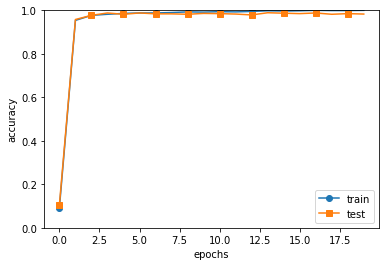

In [35]:
os.chdir("/Users/choeunsol/deep-learning-from-scratch-master/ch07")

sys.path.append(os.pardir)
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten = False)

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## CNN 시각화하기

CNN을 구성하는 합성곱 계층은 입력으로 받은 이미지 데이터에서 '무엇을 보고 있는' 것일까?

이번 절에서는 합성곱 계층을 시각화해서 CNN이 보고 있는 것이 무엇인지 보도록 하겠다.

### 1번째 층의 가중치 시각화하기

조금 앞에서 MNIST 데이터셋으로 간단한 CNN 학습을 해보았고, 그 때 1번째 층의 합성곱 계층의 가중치는 그 형상이 $(30, 1, 5, 5)$ 이다. 필터의 크기가 5 x 5이고, 채널이 1개라는 것은 이 필터를 1채널의 회색조 이미지로 시각화할 수 있다는 뜻이다.

그럼 합성곱 계층 (1층 째) 필터를 이미지로 나타내보자. 그 결과는 이처럼 된다.

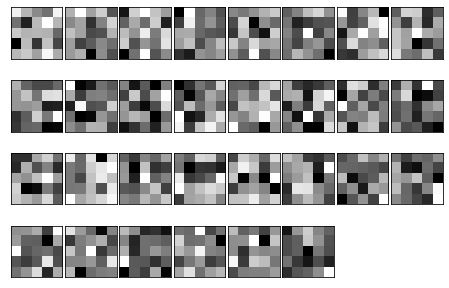

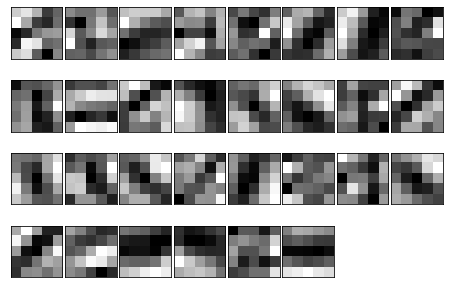

In [36]:
from visualize_filter import *

학습 전의 필터(위의 이미지들)는 무작위로 초기화되고 있어 흑백의 정도에 규칙성이 없다.

한편, 학습을 마친 필터(아래 이미지들)는 규칙성 있는 이미지가 되었다. 흰색에서 검은색으로 점차 변화하는 필터와 덩어리가 진 필터 등, 규칙을 띄는 필터로 바꾸었다.

그렇다면 아래 필터는 무엇을 보고 잇는 것일까? 그것은 **에지(색상이 바뀐 경계선)와 블롭(국소적으로 덩어리진 영역)** 등을 보고 있다. 가령 왼쪽 절반이 흰색이고 오른쪽 절반이 검은색인 필터는 세로 방향의 에지에 반응하는 필터이다.

이처럼 합성곱 계층의 필터는 에지나 블롭 등의 원시적인 정보를 추출할 수 있다. 이런 **원시적인 정보가 뒷단 계층에 전달된다는 것이 앞에서 구현한 CNN에서 일어나는 일**이다.

### 층 깊이에 따른 추출 정보 변화

앞 절의 결과는 1번째 층의 합성곱 계층을 대상으로 한 것이다.

이 층은 에지와 블롭 등의 저수준 정보가 추출된다 치고, 그럼 CNN의 각 계층에서는 어떤 정보가 추출될까?

딥러닝 시각화에 관한 연구에 따르면, 계층이 깊어질수록 추출되는 정보(정확히는 강하게 반응하는 뉴런)는 더 추상화된다는 것을 알 수 있다.

[그림 7-26]은 일반 사물 인ㅅ기을 수행한 8층의 CNN이다. 이 네트워크 구조는 AlexNet이라고 하는데, 합성곱 계층과 풀링 계층을 여러 겹 쌓고, 마지막으로 완전연결 계층을 거쳐 결과를 출력하는 구조이다.

[그림 7-26]에서 블록으로 나타낸 것은 중간 데이터이며, 그 중간 데이터에 합성곱 연산을 연속해서 적용한다.

<font color = blue> [257페이지 그림 7-26 참고] </font>

딥러닝의 흥미로운 점은 [그림 7-26]과 같이 합성곱 계층을 여러 겹 쌓으면, 층이 깊어지면서 더 복잡하고 추상화된 정보가 추출된다는 것이다. 처음 층은 단순한 에지에 반응하고, 이어서 텍스처에 반응하고, 더 복잡한 사물의 일부에 반응하도록 변화한다.

즉, **층이 깊어지면서 뉴런이 반응하는 대상이 단순한 모양에서 고급 정보로 변화**해간다.

다시 말하면 사물의 의미를 이해하도록 변화하는 것이다.

## 대표적인 CNN

이번 절에서는 CNN에서 특히 중요한 네트워크를 두 개 소개한다.

하나는 CNN의 원조인 LaNet이고, 다른 하나는 딥러닝이 주목받도록 이끈 AlexNet이다.

### LaNet

LaNet은 손글씨 숫자를 인식하는 네트워크로, 합성곱 계층과 풀링 계층(정확히는 단순히 **'원소를 줄이기'만 하는** 서브샘플링 계층)을 반복하고, 마지막으로 완전연결 계층을 거치면서 결과를 출력한다.

<font color = blue> [258페이지 그림 7-27 참고] </font>

LaNet과 현재의 CNN을 비교하면 몇 가지 면에서 차이가 있따.

첫 번째 차이는 활성화 함수이다. LaNet은 시그모이드 함수를 사용하고, 현재는 ReLU를 주로 사용한다.

또한, 원래의 LaNet은 서브샘플링을 하여 중간 데이터를 크기를 줄이지만 현재는 최대 풀링이 주류이다.

### AlexNet

AlexNet은 합성곱 계층과 풀링 계층을 거듭하여 마지막으로 완전연결 계층을 거쳐 결과를 출력한다.

LaNet과 다른 점은;

    - 활성화 함수로 ReLU를 이용한다.
    - LRN이라는 국소적 정규화를 실시하는 계층을 이용한다.
    - 드롭아웃을 사용한다.
    
이상에서 보듯 네트워크 구성 면에서는 LaNet과 AlexNet에 큰 차이는 없다. 하지만 컴퓨터 기술이 발전하면서 대량의 연산을 고속으로 수행할 수 있게 되었다.